In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pybrain.datasets import SequentialDataSet
from itertools import cycle
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import LSTMLayer
from pybrain.supervised import RPropMinusTrainer

In [3]:
##Essential functions - RUN everytime 
#For a list of non hidden files
def listdir_nohidden(path):
    list_files = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            list_files.append(f)
    return list_files

In [4]:
#Autogenerating all file names
dirpath = os.path.dirname(os.getcwd())
datapath = os.path.join(dirpath, 'data/HITS/SNe/')
list_files = listdir_nohidden(datapath)
#creating a list of files with only 'g' suffix since g band has more data
g_check = [files.split('_')[5] == 'g.dat' for files in list_files]
g_list_files = [files for files, check in zip(list_files, g_check) if check]

In [5]:
def data_explore(datapath, filename, create_fig=False):
    #creating a normal and a difference plot
    filepath = datapath + filename
    sn = pd.read_csv(filepath, sep='\s+', skiprows=1, header=None)
    sn.columns =['Epoch', 'MJD', 'Mag_auto', 'Mag_err_auto','Flux_auto', 'Flux_err_auto']
    time_norm_factor = 100
    time_vec = np.array(sn['MJD'])*time_norm_factor
    time_vec = np.floor(time_vec - time_vec[0])
    #Calculating the derivative at every point
    derivative = np.divide(np.diff(sn['Mag_auto']), np.diff(sn['MJD']))
    #Setting up the figure
    if create_fig == True:
        f, axarr = plt.subplots(1, 2, figsize=(10,10))
        #plotting the data in subplot 1
        axarr[0].plot(time_vec, sn['Mag_auto'])
        axarr[0].set_xlabel('Time Steps')
        axarr[0].set_ylabel('Magnitude')
        axarr[0].set_title('Time series plot')
        axarr[1].plot(time_vec[1:], derivative)
        axarr[1].set_xlabel('Time Steps')
        axarr[1].set_ylabel('Magnitude')
        axarr[1].set_title('Difference plot at n=1')
        plt.savefig('../graphs/SNe/'+filename+'.png')
        plt.close()

In [6]:
for files in g_list_files:
    data_explore(datapath, files, create_fig=True)

#### Creating functions for training RNN's from HITS data

In [37]:
#genfolderHITS - returns list of folders from the HITS folder
#Specific only to HITS files
def genfolderHITS(datapath):
    return listdir_nohidden(datapath)
#genfiles - creates a list of files from the folder specified and 
#a folderpath for accessing the genfiles
def genfiles(datapath, folder, band='g'):
    bandSuffix = band+'.dat'
    folderpath = os.path.join(datapath, folder+'/')
    fileList = listdir_nohidden(folderpath)
    gCheck = [files.split('_')[5] == bandSuffix for files in fileList]
    bandFileList = [files for files, check in \
                    zip(fileList, gCheck) if check]
    return bandFileList, folderpath
#gentimeseries - returns a Sequential dataset with features
def gentimeseries(folderpath, filename, indim, outdim):
    filepath = folderpath+filename
    sn = pd.read_csv(filepath, sep='\s+', skiprows=1, header=None)
    sn.columns =['Epoch', 'MJD', 'Mag_auto', 'Mag_err_auto','Flux_auto',\
                 'Flux_err_auto']
    timeVec = np.array(sn['MJD'] - sn['MJD'][0])
    deltimeVec = np.lib.pad(np.diff(timeVec), (1,0), 'edge')
    assert len(deltimeVec) == len(timeVec)
    magnitude = np.array(sn['Mag_auto'])
    derivative = np.divide(np.diff(sn['Mag_auto']), np.diff(sn['MJD']))
    magDerivative = np.lib.pad(derivative, (1,0), 'edge')
    dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'edge')
    feature_list = [magnitude, timeVec, deltimeVec,\
                    magDerivative, dDerivative]
    feats = np.vstack(feature_list)
    ds = SequentialDataSet(indim, outdim)
    resp = np.lib.pad(magnitude[1:], (0,1), 'edge')
    for feat, res in zip(feats.T, resp):
        ds.addSample(list(feat), res)
    return ds, timeVec, magnitude

In [9]:
dirpath = os.path.dirname(os.getcwd())
datapath = os.path.join(dirpath, 'data/HITS/')
folders = genfolderHITS(datapath)
files, folderpath = genfiles(datapath, folders[0])

#### Training the LSTM network for the above vector(To test if LSTM can mimic the shape)

In [40]:
def trainLSTM(net, cycles, dataset, epochs_per_cycle, lstmLayerWidth):
    trainer = RPropMinusTrainer(net, dataset = dataset)
    for i in xrange(cycles+1):
        trainer.trainEpochs(epochs_per_cycle)
    state_values = [[] for k in range(lstmLayerWidth)]
    state_val = list(net['hidden0'].state)[:len(dataset)]
    for state in state_val:
        for k in range(lstmLayerWidth):
            state_values[k].append(state[k])
    return state_values

In [28]:
##Error function
def error_in_prediction(predicted_sample, actual_next_sample):
    if type(predicted_sample) is list:
        predicted_sample = np.array(predicted_sample)
    if type(actual_next_sample) is list:
        actual_next_sample = np.array(actual_next_sample)
    error = np.mean(np.square(predicted_sample - actual_next_sample))
    return error

In [130]:
##Plotting function
def gen_state_iteration_plot(lstm_width, state_values, net, ds,\
        it_num, name, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    if lstm_width < 5:
        axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    current_input = []
    predicted_sample = []
    actual_next_sample = []
    time =[]
    for sample, target in ds.getSequenceIterator(0):
        current_input.append(sample[0])
        time.append(sample[1])
        predicted_sample.append(net.activate(sample))
        actual_next_sample.append(target)

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(time,current_input, label='Input')
    axarr[0,1].plot(time,predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(time,actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('../graphs/SNe/LSTM/'\
                    +str(lstm_width)+'_'\
            +name+'_'+str(it_num)+'.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

In [122]:
#Specifying parameters for the LSTM
lstmLayerWidth = 50
outdim = 1
indim = 5
cycles_per_file = 500
epochs_per_cycle = 1
numfiles = 100
net = buildNetwork(indim,lstmLayerWidth,outdim, hiddenclass=LSTMLayer, \
                       outputbias=False, recurrent=True)  

In [123]:
dirpath = os.path.dirname(os.getcwd())
datapath = os.path.join(dirpath, 'data/HITS/')
folders = genfolderHITS(datapath)
print folders
files, folderpath = genfiles(datapath, folders[6])
timeseries, timeVec, mag = gentimeseries(folderpath,\
                                    files[6], indim, outdim)

['CEP', 'EB', 'NV', 'QSO', 'Rand', 'RRLy', 'SNe']


In [124]:
state_values = trainLSTM(net, cycles_per_file, timeseries, epochs_per_cycle, lstmLayerWidth)

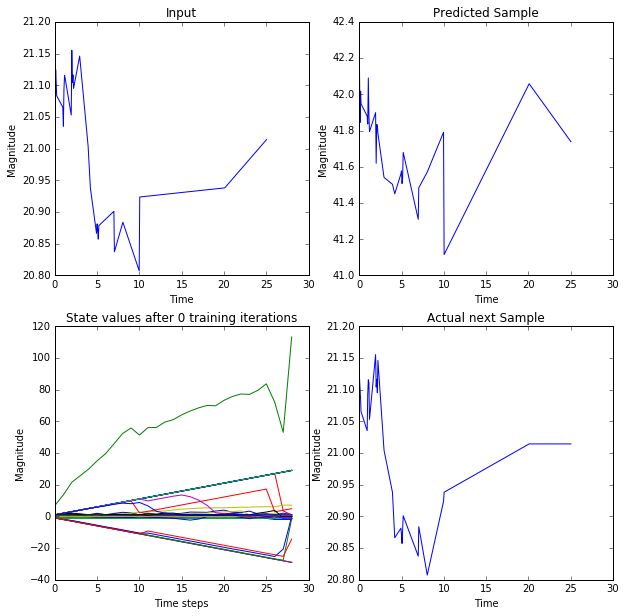

Error in prediction :429.395072722


In [125]:
gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, timeseries, 0, 'SN')

##### Automating code for all the Supernova files

In [132]:
dirpath = os.path.dirname(os.getcwd())
datapath = os.path.join(dirpath, 'data/HITS/')
folders = genfolderHITS(datapath)
files, folderpath = genfiles(datapath, folders[6])
for f in files:
    timeseries, timeVec, mag = gentimeseries(folderpath,\
                                    f, indim, outdim)
    lstmLayerWidth = 50
    outdim = 1
    indim = 5
    cycles_per_file = 500
    epochs_per_cycle = 1
    net = buildNetwork(indim,lstmLayerWidth,outdim, hiddenclass=LSTMLayer, \
                       outputbias=False, recurrent=True)
    state_values = trainLSTM(net, cycles_per_file, timeseries, epochs_per_cycle, lstmLayerWidth)
    gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, timeseries, cycles_per_file, 'SN'+f, save=True)

Error in prediction :400.291869249
Error in prediction :459.184995002
Error in prediction :546.293510497
Error in prediction :517.324356219
Error in prediction :438.278194283
Error in prediction :530.401453249
Error in prediction :431.121370287
Error in prediction :461.407472627
Error in prediction :467.015361602
Error in prediction :422.832773823


In [128]:
files

['Blind15A_07_N2_1214_3860_g.dat',
 'Blind15A_12_S28_0091_2772_g.dat',
 'Blind15A_20_N28_0704_3068_g.dat',
 'Blind15A_33_N28_0247_0498_g.dat',
 'Blind15A_34_N27_1247_0774_g.dat',
 'Blind15A_41_N9_1852_3247_g.dat',
 'Blind15A_42_S9_1021_1230_g.dat',
 'Blind15A_43_N25_0814_0140_g.dat',
 'Blind15A_47_N7_0329_0663_g.dat',
 'Blind15A_47_S27_0978_3515_g.dat']